<a href="https://colab.research.google.com/github/suryanshu07/Disease-Classification/blob/main/Insaid_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the dependencies**

In [138]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### **Importing the data**

In [139]:
data = pd.read_csv('/content/Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [140]:
data.shape

(6362620, 11)

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## **Exploratory Data Analysis**

In [142]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

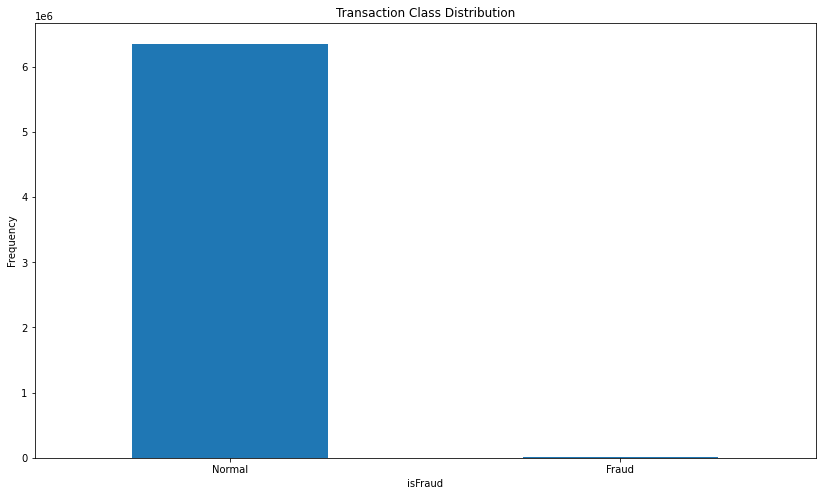

In [143]:
count_classes = pd.value_counts(data['isFraud'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("isFraud")

plt.ylabel("Frequency")

In [144]:
## Get the Fraud and the normal dataset 

fraud = data[data['isFraud']==1]

normal = data[data['isFraud']==0]

In [145]:
print(fraud.shape,normal.shape)

(8213, 11) (6354407, 11)


In [146]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [147]:
normal.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

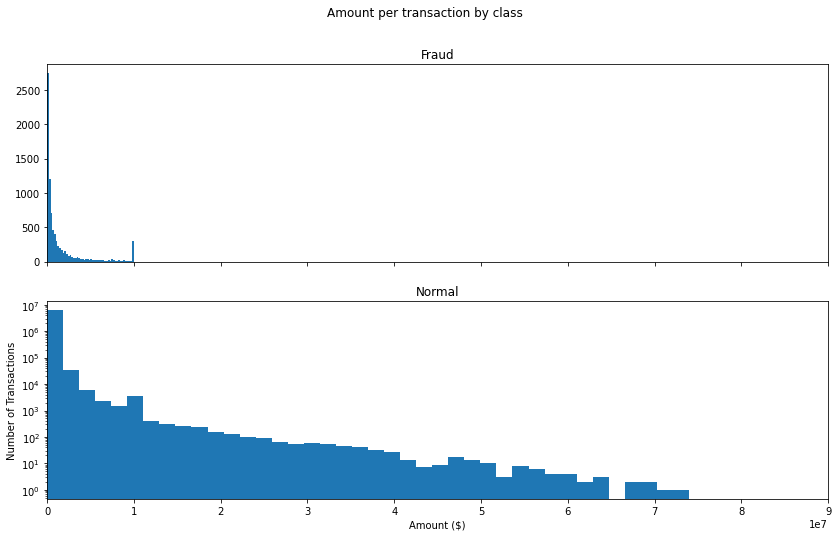

In [151]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 90000000))
plt.yscale('log')
plt.show();

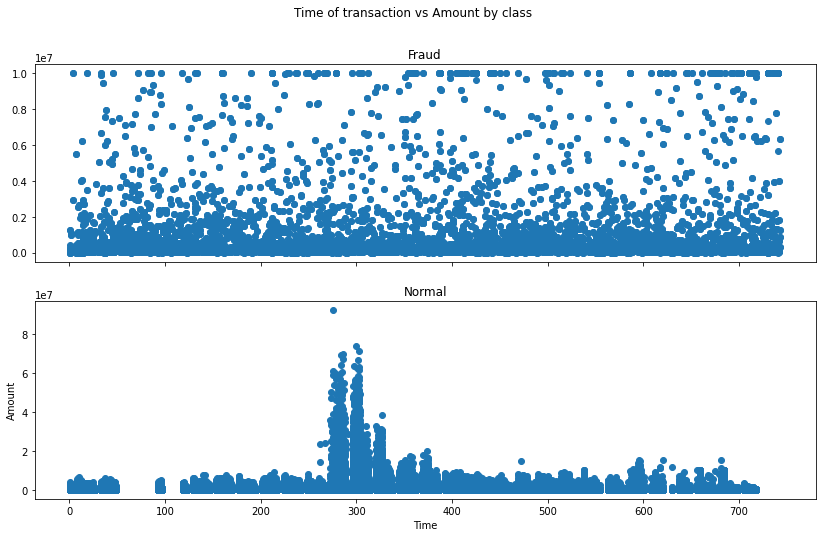

In [152]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.step, fraud.amount)
ax1.set_title('Fraud')
ax2.scatter(normal.step, normal.amount)
ax2.set_title('Normal')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

In [153]:
X = data.iloc[:,1:10]

In [154]:
X

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


In [155]:
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [156]:
ohe = OneHotEncoder(drop='first',sparse=False)

In [157]:
feature_arry = ohe.fit_transform(X[['type']])

In [158]:
feature_arry.shape

(6362620, 4)

In [159]:
feature_arry

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [160]:
encoded = pd.DataFrame(feature_arry,columns=['CASH_OUT','DEBIT','PAYMENT','TRANSFER'])

In [161]:
encoded_df = pd.concat([X,encoded],axis=1)
encoded_df

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0.0,0.0,1.0,0.0
1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0.0,0.0,1.0,0.0
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0.0,0.0,0.0,1.0
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,1.0,0.0,0.0,0.0
4,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,1.0,0.0,0.0,0.0
6362616,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0.0,0.0,0.0,1.0
6362617,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,1.0,0.0,0.0,0.0
6362618,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0.0,0.0,0.0,1.0


In [162]:
encoded_df = encoded_df.drop('type',axis=1)

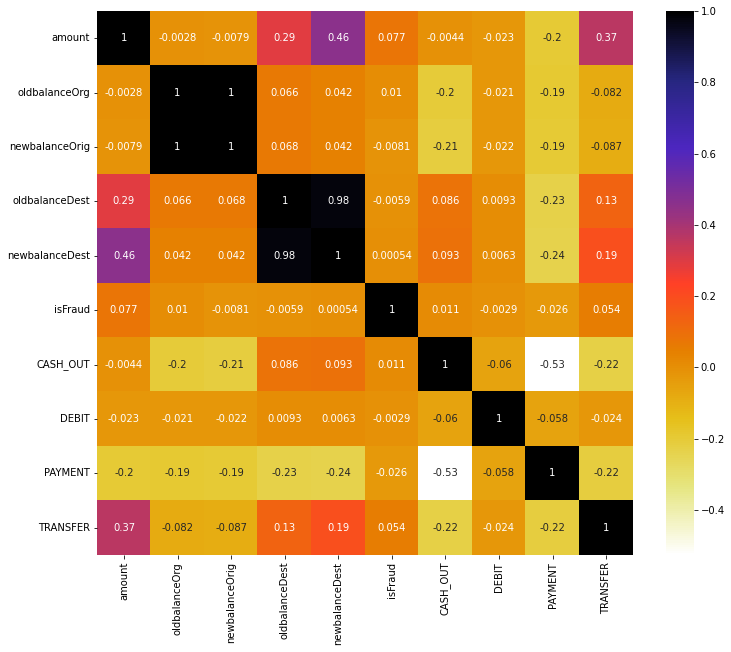

In [163]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = encoded_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [164]:
encoded_df

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0.0,0.0,1.0,0.0
1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0.0,0.0,1.0,0.0
2,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0.0,0.0,0.0,1.0
3,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,1.0,0.0,0.0,0.0
4,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,1.0,0.0,0.0,0.0
6362616,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0.0,0.0,0.0,1.0
6362617,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,1.0,0.0,0.0,0.0
6362618,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0.0,0.0,0.0,1.0


In [165]:
encoded_df.drop(encoded_df.columns[[1, 2, 3, 4, 5, 6]], axis=1, inplace=True)

In [166]:
encoded_df

,amount,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,0,0.0,0.0,1.0,0.0
1,1864.28,0,0.0,0.0,1.0,0.0
2,181.00,1,0.0,0.0,0.0,1.0
3,181.00,1,1.0,0.0,0.0,0.0
4,11668.14,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
6362615,339682.13,1,1.0,0.0,0.0,0.0
6362616,6311409.28,1,0.0,0.0,0.0,1.0
6362617,6311409.28,1,1.0,0.0,0.0,0.0
6362618,850002.52,1,0.0,0.0,0.0,1.0


In [167]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
scaled_arry = scaling.fit_transform(encoded_df[['amount']])
scaled_arry

array([[-0.28155992],
       [-0.29476726],
       [-0.2975548 ],
       ...,
       [10.1539526 ],
       [ 1.1097649 ],
       [ 1.1097649 ]])

In [168]:
scaled_cat = encoded_df.drop('amount', axis=1)
scaled_cat

,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0.0,0.0,1.0,0.0
1,0,0.0,0.0,1.0,0.0
2,1,0.0,0.0,0.0,1.0
3,1,1.0,0.0,0.0,0.0
4,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
6362615,1,1.0,0.0,0.0,0.0
6362616,1,0.0,0.0,0.0,1.0
6362617,1,1.0,0.0,0.0,0.0
6362618,1,0.0,0.0,0.0,1.0


In [169]:
encoded_amount = pd.DataFrame(scaled_arry,columns=['amount'])

In [170]:
encoded_df = pd.concat([scaled_cat,encoded_amount],axis=1)

In [177]:
encoded_df

,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,amount
0,0,0.0,0.0,1.0,0.0,-0.281560
1,0,0.0,0.0,1.0,0.0,-0.294767
2,1,0.0,0.0,0.0,1.0,-0.297555
3,1,1.0,0.0,0.0,0.0,-0.297555
4,0,0.0,0.0,1.0,0.0,-0.278532
...,...,...,...,...,...,...
6362615,1,1.0,0.0,0.0,0.0,0.264665
6362616,1,0.0,0.0,0.0,1.0,10.153953
6362617,1,1.0,0.0,0.0,0.0,10.153953
6362618,1,0.0,0.0,0.0,1.0,1.109765


In [178]:
legit = encoded_df[encoded_df.isFraud == 0]
fraud = encoded_df[encoded_df.isFraud == 1]

In [179]:
print(legit.shape,fraud.shape)

(6354407, 6) (8213, 6)


### **Under-Sampling**

Building a sample dataset containing similar distribution of normal transactions and fraudulent transactions

Number of fraudulent transactions --> 8213

In [180]:
 legit_sample = legit.sample(n=8213)

Concatenate two DataFrames

In [181]:
new_dataset = pd.concat([legit_sample, fraud], axis=0)

In [185]:
new_dataset.head()

,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,amount
4814284,0,0.0,0.0,1.0,0.0,-0.231424
5691299,0,0.0,0.0,0.0,0.0,0.051821
382827,0,0.0,0.0,0.0,0.0,-0.019215
2790519,0,0.0,0.0,0.0,0.0,-0.025437
5321748,0,0.0,0.0,1.0,0.0,-0.248941


Splitting the data into Features and Targets

In [186]:
X = new_dataset.drop(columns='isFraud', axis=1)
Y = new_dataset['isFraud']

In [187]:
print(X)
print(Y)

         CASH_OUT  DEBIT  PAYMENT  TRANSFER     amount
4814284       0.0    0.0      1.0       0.0  -0.231424
5691299       0.0    0.0      0.0       0.0   0.051821
382827        0.0    0.0      0.0       0.0  -0.019215
2790519       0.0    0.0      0.0       0.0  -0.025437
5321748       0.0    0.0      1.0       0.0  -0.248941
...           ...    ...      ...       ...        ...
6362615       1.0    0.0      0.0       0.0   0.264665
6362616       0.0    0.0      0.0       1.0  10.153953
6362617       1.0    0.0      0.0       0.0  10.153953
6362618       0.0    0.0      0.0       1.0   1.109765
6362619       1.0    0.0      0.0       0.0   1.109765

[16426 rows x 5 columns]
4814284    0
5691299    0
382827     0
2790519    0
5321748    0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 16426, dtype: int64


In [188]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [190]:
print(X.shape, X_train.shape, X_test.shape)

(16426, 5) (13140, 5) (3286, 5)


Model Training

In [172]:
Y = encoded_df[['isFraud']]

In [173]:
encoded_df.columns

Index(['isFraud', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'amount'], dtype='object')

In [174]:
X = encoded_df[['CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'amount']]

In [175]:
Y

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
6362615,1
6362616,1
6362617,1
6362618,1
